#### Project: Dynamic Pricing Optimization for E-commerce
In this project, we will develop a demand forecasting model to optimize pricing dynamically. The model will analyze customer behavior, seasonality, and competitor pricing using time-series analysis (e.g., ARIMA, Prophet) or deep learning (e.g., LSTMs). The output will be used to adjust prices dynamically to maximize revenue while maintaining demand.

#### Step-by-Step Guide
1. Problem Definition
The goal is to:

Predict future product demand based on historical data.
Use the forecasted demand to adjust prices dynamically to optimize revenue while maintaining demand.
2. Dataset Overview
The dataset contains the following columns:

InvoiceNo : Unique identifier for each transaction.
StockCode : Product code (unique identifier for each product).
Description : Product description.
Quantity : Number of units sold in a transaction.
InvoiceDate : Date and time of the transaction.
UnitPrice : Price per unit of the product.
CustomerID : Unique identifier for the customer (optional; used for customer segmentation if needed).
Country : Country where the transaction occurred.
We will aggregate the data by StockCode and InvoiceDate to create time-series data for demand forecasting.uation.ptional).enue.


##### Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import MeanSquaredError

##### Step 2: Load and Explore the Dataset

In [2]:
# Load dataset
data = pd.read_csv('ecommerce_sales.csv', encoding='ISO-8859-1')

In [3]:
# Inspect the first few rows
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# Check for missing values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# Drop rows with missing values
data.dropna(inplace=True)

In [6]:
# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [7]:
# Aggregate data by StockCode and InvoiceDate
grouped_data = data.groupby(['StockCode', 'InvoiceDate']).agg({
    'Quantity': 'sum',  # Total quantity sold
    'UnitPrice': 'mean'  # Average price per unit
}).reset_index()

In [8]:
# Focus on one product for simplicity (e.g., StockCode == '85123A')
product_data = grouped_data[grouped_data['StockCode'] == '85123A']

In [9]:
# Set InvoiceDate as the index
product_data.set_index('InvoiceDate', inplace=True)

In [10]:
# Resample data to daily frequency
product_data = product_data.resample('D').sum()

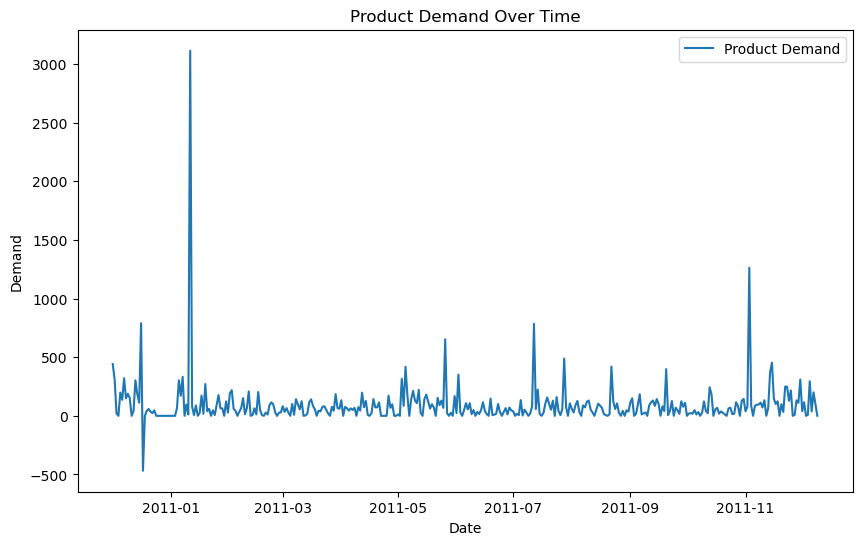

In [11]:
# Visualize sales over time
plt.figure(figsize=(10, 6))
plt.plot(product_data.index, product_data['Quantity'], label='Product Demand')
plt.title('Product Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

#### Step 3: Preprocess the Data

In [12]:
# Handle missing values (fill with 0 for days with no sales)
product_data.fillna(0, inplace=True)

In [13]:
# Feature engineering: Add seasonality indicators
product_data['Year'] = product_data.index.year
product_data['Month'] = product_data.index.month
product_data['DayOfWeek'] = product_data.index.dayofweek
product_data['IsWeekend'] = product_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [14]:
# Normalize numerical features
scaler = MinMaxScaler()
product_data[['Quantity', 'UnitPrice']] = scaler.fit_transform(product_data[['Quantity', 'UnitPrice']])

#### Step 4: Train a Prophet Model

In [15]:
# Prepare data for Prophet
prophet_data = product_data.reset_index()[['InvoiceDate', 'Quantity']].rename(columns={'InvoiceDate': 'ds', 'Quantity': 'y'})

In [16]:
# Split into train and test sets
train_size = int(len(prophet_data) * 0.8)
train_prophet = prophet_data[:train_size]
test_prophet = prophet_data[train_size:]

In [17]:
# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

19:03:32 - cmdstanpy - INFO - Chain [1] start processing
19:03:33 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Forecast demand
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast = prophet_model.predict(future)

In [19]:
# Extract forecasted values
forecast_values = forecast[['ds', 'yhat']].tail(len(test_prophet))

In [20]:
# Evaluate performance
mse = mean_squared_error(test_prophet['y'], forecast_values['yhat'])
mae = mean_absolute_error(test_prophet['y'], forecast_values['yhat'])
print(f"Prophet MSE: {mse}, MAE: {mae}")

Prophet MSE: 0.00212421198717852, MAE: 0.024151026480990493


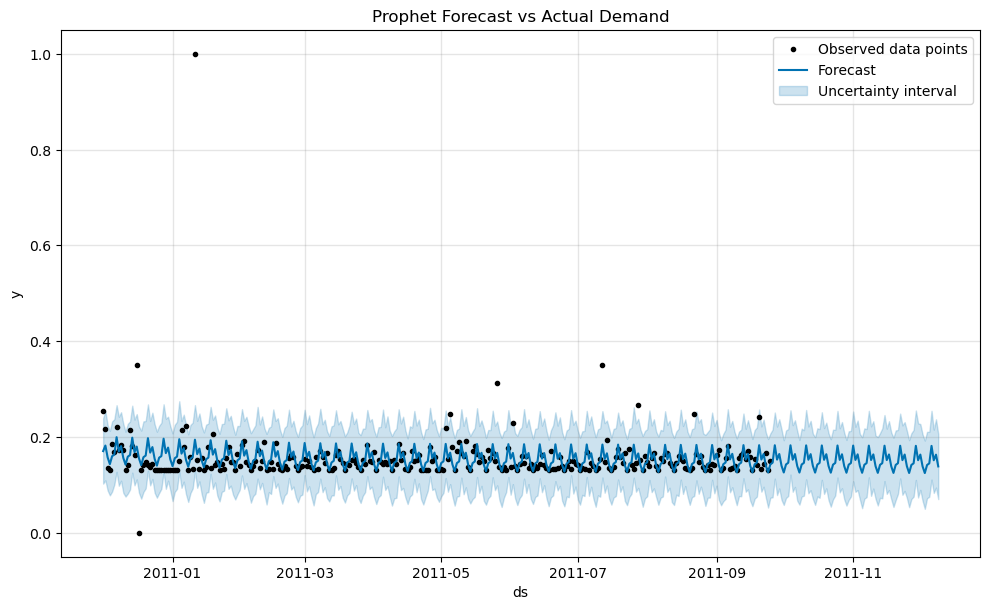

In [21]:
# Plot results
prophet_model.plot(forecast)
plt.title('Prophet Forecast vs Actual Demand')
plt.legend()
plt.show()

#### Step 5: Train an LSTM Model

In [22]:
# Prepare data for LSTM
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data['Quantity'].values[i-look_back:i])
        y.append(data['Quantity'].values[i])
    return np.array(X), np.array(y)

look_back = 60
X, y = create_dataset(product_data, look_back)

In [23]:
# Split into train and test
X_train, X_test = X[:train_size-look_back], X[train_size:]
y_train, y_test = y[:train_size-look_back], y[train_size:]

In [24]:
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [26]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0276 - val_loss: 0.0176
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0123 - val_loss: 0.0069
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0014 - val_loss: 8.9115e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 6.2876e-04 - val_loss: 0.0011
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 8.4816e-04 - val_loss: 9.6915e-04
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0011 - val_loss: 8.7853e-04
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.6984e-04 - val_loss: 8.8290e-04
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7.2322e-04 - val_loss: 8.9776e-04
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.4668e-04 - val_loss: 9.1194e-04
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [28]:
# Forecast demand
lstm_forecast = lstm_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


In [29]:
# Evaluate performance
mse = mean_squared_error(y_test, lstm_forecast)
mae = mean_absolute_error(y_test, lstm_forecast)
print(f"LSTM MSE: {mse}, MAE: {mae}")

LSTM MSE: 0.0008911693359552657, MAE: 0.024711836535626815


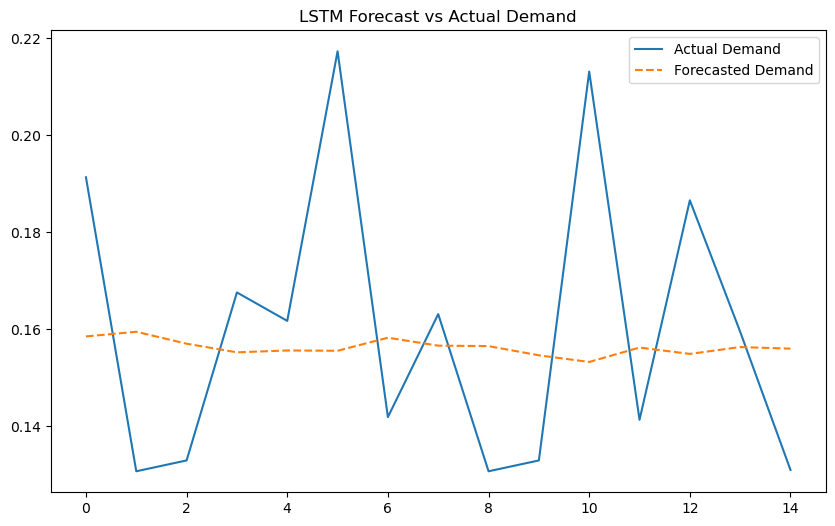

In [30]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Demand')
plt.plot(lstm_forecast, label='Forecasted Demand', linestyle='--')
plt.title('LSTM Forecast vs Actual Demand')
plt.legend()
plt.show()

#### Step 6: Optimize Pricing Dynamically

In [31]:
# Example: Adjust price based on forecasted demand
def optimize_price(demand, base_price, elasticity=-1.5):
    optimal_price = base_price * (1 + elasticity * (demand - np.mean(demand)) / np.mean(demand))
    return max(optimal_price, 0)  # Ensure price is non-negative

In [32]:
# Apply optimization
test_prophet['OptimalPrice'] = test_prophet['y'].apply(lambda x: optimize_price(x, base_price=50))

C:\Users\hp\AppData\Local\Temp\ipykernel_5240\822202310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet['OptimalPrice'] = test_prophet['y'].apply(lambda x: optimize_price(x, base_price=50))


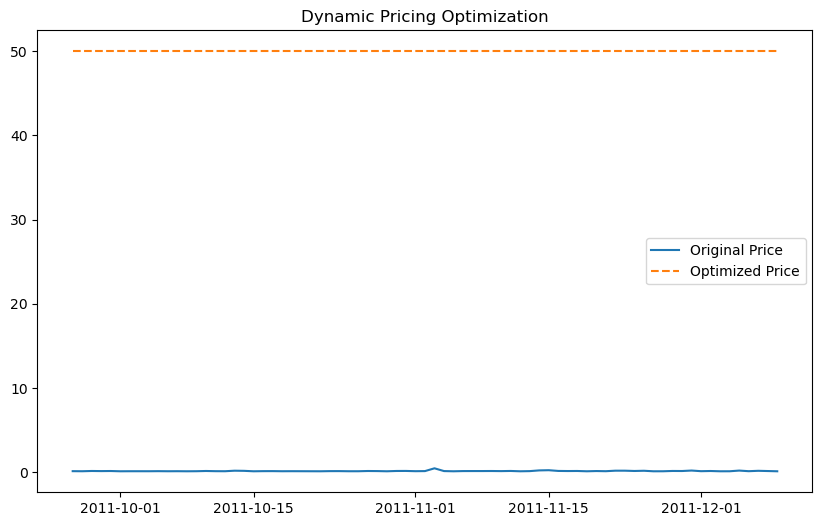

In [33]:
# Plot optimized prices
plt.figure(figsize=(10, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Original Price')
plt.plot(test_prophet['ds'], test_prophet['OptimalPrice'], label='Optimized Price', linestyle='--')
plt.title('Dynamic Pricing Optimization')
plt.legend()
plt.show()

#### Key Points
Data Aggregation : The dataset was aggregated by StockCode and InvoiceDate to create time-series data.
Model Selection : Prophet and LSTM models were used for demand forecasting.
Dynamic Pricing : Prices were adjusted dynamically based on forecasted demand using a simple elasticity-based formula.

#### Step 7: Train the ARIMA Model

In [34]:
# Split data into train and test sets
train_size = int(len(product_data) * 0.8)
train, test = product_data['Quantity'][:train_size], product_data['Quantity'][train_size:]

In [35]:
# Fit ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))  # (p=5, d=1, q=0)
arima_fit = arima_model.fit()

In [36]:
# Forecast demand
forecast = arima_fit.forecast(steps=len(test))

In [37]:
# Evaluate performance
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f"ARIMA MSE: {mse}, MAE: {mae}")

ARIMA MSE: 0.002133617506014322, MAE: 0.02282557320071544


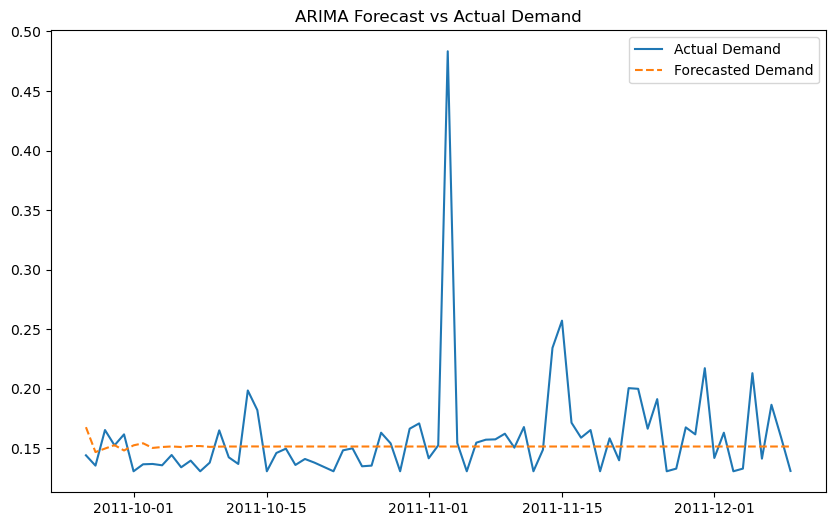

In [38]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Demand')
plt.plot(test.index, forecast, label='Forecasted Demand', linestyle='--')
plt.title('ARIMA Forecast vs Actual Demand')
plt.legend()
plt.show()

#### Step 8: Optimize Pricing Dynamically

In [39]:
# Example: Adjust price based on forecasted demand
def optimize_price(demand, base_price, elasticity=-1.5):
    optimal_price = base_price * (1 + elasticity * (demand - np.mean(demand)) / np.mean(demand))
    return max(optimal_price, 0)  # Ensure price is non-negative

In [40]:
# Apply optimization
test_df = test.reset_index()
test_df['OptimalPrice'] = test_df['Quantity'].apply(lambda x: optimize_price(x, base_price=50))

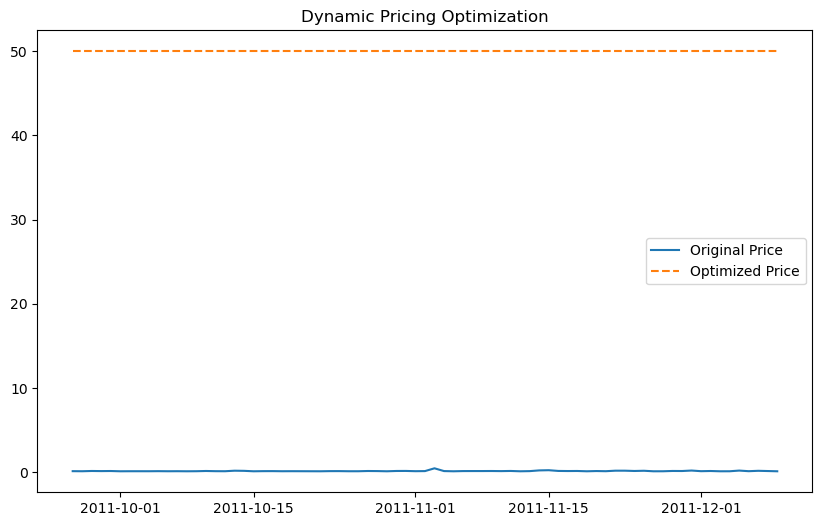

In [41]:
# Plot optimized prices
plt.figure(figsize=(10, 6))
plt.plot(test_df['InvoiceDate'], test_df['Quantity'], label='Original Price')
plt.plot(test_df['InvoiceDate'], test_df['OptimalPrice'], label='Optimized Price', linestyle='--')
plt.title('Dynamic Pricing Optimization')
plt.legend()
plt.show()

#### Explanation of Key Steps
1. ARIMA Model Parameters
p (AutoRegressive term) : Number of lag observations included in the model.
d (Differencing term) : Number of times the data has been differenced to make it stationary.
q (Moving Average term) : Size of the moving average window.
In this example, we used (p=5, d=1, q=0):

p=5: We considered 5 lagged observations.
d=1: The data was differenced once to achieve stationarity.
q=0: No moving average component was included.
You can tune these parameters using techniques like grid search or AIC/BIC criteria .

2. Dynamic Pricing Logic
The pricing logic assumes that demand elasticity (elasticity) determines how sensitive customers are to price changes. For example:

If demand increases, the price can be raised slightly.
If demand decreases, the price can be lowered to maintain sales volume.

#### Key Takeaways
ARIMA for Time-Series Forecasting : ARIMA is effective for modeling stationary time-series data with clear trends and seasonality.
Dynamic Pricing : By combining demand forecasts with elasticity-based pricing, businesses can optimize revenue while maintaining customer satisfaction.
Scalability : This pipeline can be extended to multiple products and deployed in production using tools like Flask or FastAPI.

In [55]:
import joblib

# Save the ARIMA model
arima_fit.save('arima_model.pkl')

In [56]:
import pickle

# Save the Prophet model
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)

In [42]:
from tensorflow.keras.models import load_model

lstm_model.save('lstm_model.keras')  # This uses the new SavedModel format
# Save the LSTM model
# lstm_model.save('lstm_model.h5')